In [1]:
import Pkg; Pkg.add("JuMP")
import Pkg; Pkg.add("GLPK")
import Pkg; Pkg.add("CSV")
import Pkg; Pkg.add("DataFrames")
import Pkg; Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
using JuMP, GLPK, CSV, DataFrames

# Load data
requirements = Matrix(CSV.read("HW1_data/requirements.csv", DataFrame))
availability = Matrix(CSV.read("HW1_data/availability.csv", DataFrame))
demand = Matrix(CSV.read("HW1_data/demand.csv", DataFrame))
profit = Vector(CSV.read("HW1_data/profit.csv", DataFrame)[:, 1])
holding = Vector(CSV.read("HW1_data/holding.csv", DataFrame)[:, 1])

model = Model(GLPK.Optimizer)

# variables
@variable(model, x[1:20, 1:52] >= 0)  #produced
@variable(model, y[1:20, 1:52] >= 0)  #stored
@variable(model, s[1:20, 1:52] >= 0)  #sold

#maximize net profit over time across all products sol
@objective(model, Max, 
    sum(profit[i] * s[i,t] - holding[t] * y[i,t] for i in 1:20, t in 1:52))


# material
for j in 1:500, t in 1:52
    @constraint(model, sum(requirements[j,i] * x[i,t] for i in 1:20) <= availability[j,t])
end

# inventory
for i in 1:20, t in 1:52
    if t == 1
        @constraint(model, y[i,t] == x[i,t] - s[i,t])
    else
        @constraint(model, y[i,t] == y[i,t-1] + x[i,t] - s[i,t])
    end
end

# for i in 1:20
#     @constraint(model, sum(y[i, 1])==0)
# end

@constraint(model, [i=1:20, t=1:52], s[i,t] <= demand[i,t])

optimize!(model)

# results
production = value.(x)
inventory = value.(y)
sales = value.(s)

#  profits and costs
sales_profit = sum(profit[i] * sales[i,t] for i in 1:20, t in 1:52)
holding_cost = sum(holding[t] * inventory[i,t] for i in 1:20, t in 1:52)

println("Sales Profit: $(sales_profit)")
println("Holding Cost: $(holding_cost)") 
println("Net Profit: $(sales_profit - holding_cost)")

Sales Profit: 206944.2943669845
Holding Cost: 246.8189527929788
Net Profit: 206697.47541419155


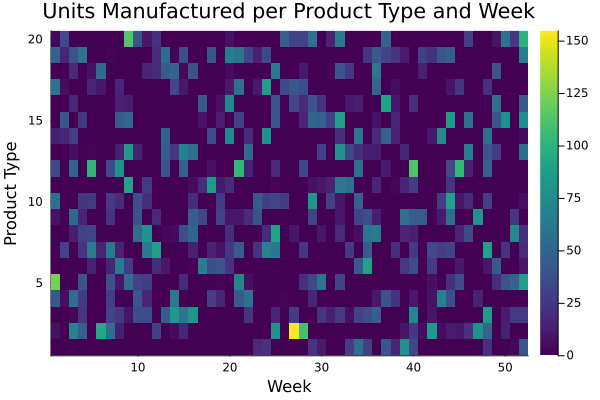

In [3]:
using Plots

heatmap(1:52, 1:20, production', 
    xlabel="Week", ylabel="Product Type", 
    title="Units Manufactured per Product Type and Week",
    color=:viridis)

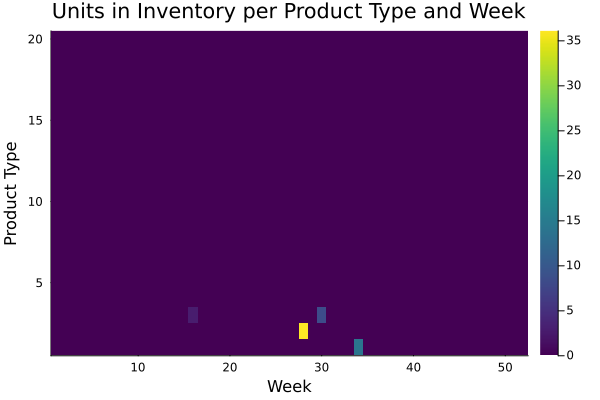

In [4]:
using Plots

heatmap(1:52, 1:20, production', 
    xlabel="Week", ylabel="Product Type", 
    title="Units Manufactured per Product Type and Week",
    color=:viridis)

num_products_manufactured = [sum(production[:,t] .> 0) for t in 1:52]
plot(1:52, num_products_manufactured, 
    xlabel="Week", ylabel="Number of Product Types", 
    title="Number of Product Types Manufactured Each Week",
    legend=false)

heatmap(1:52, 1:20, inventory', 
    xlabel="Week", ylabel="Product Type", 
    title="Units in Inventory per Product Type and Week",
    color=:viridis)

In [6]:
# Number of fully utilized materials in week 30
fully_utilized_materials = sum(sum(requirements[:,i] * production[i,30] for i in 1:20) .≈ availability[:,30])

# Number of products with fully satisfied demand in week 30
fully_satisfied_products = sum(sales[:,30] .≈ demand[:,30])

println("Number of fully utilized materials in week 30: ", fully_utilized_materials)
println("Number of products with fully satisfied demand in week 30: ", fully_satisfied_products)

Number of fully utilized materials in week 30: 6
Number of products with fully satisfied demand in week 30: 1
